<div style="text-align: right;">
<a target="_blank" href="https://colab.research.google.com/github/hkaragah/hkaragah.github.io/blob/main/structure/p_delta/cant_col_p_delta.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
</div>

# Rectangular Concrete Shear Wall Neutral Axis

In [1]:
import os
import sys
sys.path.append(os.path.abspath("../../assets/modules/"))
from materials import Concrete, BilinearSteel
from shapes import Rectangle, Circle
from concrete import *
from steel import RebarSection
import pandas as pd

In [2]:
# Define rebar material with fy = 60 ksi
a706_60 = BilinearSteel(name='A706 Gr.60', fy=60e3, fu=80e3, alpha=0.0) # A706 Gr. 60 low-alloy steel

# Define rebar sections
r_11 = RebarSection(size=11, bar_mat=a706_60) # No. 11 rebar
r_8 = RebarSection(size=8, bar_mat=a706_60) # No. 8 rebar

# Define concrete material with f'c = 5000 psi
c_5000 = ACIConcrete(fc=5000)

# Define shear wall cross-section (20" x 366")
rect_366x20 = Rectangle(width=366, height=20)

# Define shear wall secion
c_sec = RectangleConcreteSection(shape=rect_366x20, concrete_mat=c_5000, cover=1.5)

In [3]:
# Add rebar to the shear wall section
c_sec.add_rebar_row(r_11, center=(-180, 7), n=7, spacing=9)
c_sec.add_rebar_row(r_11, center=(-180, -7), n=7, spacing=9)
c_sec.add_rebar(r_11, center=(-180, 0))

c_sec.add_rebar_row(r_8, center=(0, 7), n=14, spacing=9)
c_sec.add_rebar_row(r_8, center=(0, -7), n=14, spacing=9)
c_sec.add_rebar_row(r_8, center=(-9, 7), n=13, spacing=9, reverse=True)
c_sec.add_rebar_row(r_8, center=(-9, -7), n=13, spacing=9, reverse=True)

c_sec.add_rebar_row(r_11, center=(180, 7), n=7, spacing=9, reverse=True)
c_sec.add_rebar_row(r_11, center=(180, -7), n=7, spacing=9, reverse=True)
c_sec.add_rebar(r_11, center=(180, 0))


<Axes: >

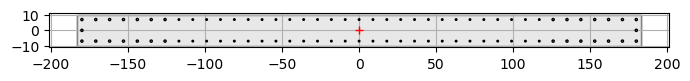

In [4]:
c_sec.plot()

In [5]:
Pu = -1060 * 1e3 # lb, external compressive axial load
phi = 0.9
Pn = Pu / phi # lb

h = max(c_sec.shape.width, c_sec.shape.height) # in
# Select one of these methods: 'secant', 'newton', 'brentq', 'bisect'
c = compute_neutral_axis(c_sec, Pn, method='secant')

print(f"Neutral axis depth: {c:.2f} in")

Neutral axis depth: 60.02 in


In [6]:
y_neutral = c
curvature = c_sec.mat.eps_u / y_neutral

y_s, eps_s, sigma_s, f_s = get_rebar_forces(concrete_sec=c_sec, curvature=curvature, y_neutral=y_neutral)
y_c, eps_c, sigma_c, f_c = get_rect_concrete_force(concrete_sec=c_sec, curvature=curvature, y_neutral=y_neutral, n_points=1000)

In [7]:
P_n1 = get_section_internal_force(concrete_sec=c_sec, curvature=curvature, y_neutral=y_neutral)
M_n1 = get_section_internal_moment(concrete_sec=c_sec, curvature=curvature, y_neutral=y_neutral)
print(f"Axial force: {P_n1/1e3:.0f} kips")
print(f"Moment: {M_n1[0]/1e3:.0f} kips-in")

Axial force: -1166 kips
Moment: -1032488 kips-in


In [8]:
unique_y = np.unique(y_s)

data = {
    'y(in)': unique_y,
    'area(in2)': np.zeros(unique_y.shape),
    'strain': np.zeros(unique_y.shape),
    'stress(ksi)': np.zeros(unique_y.shape),
    'force(kips)': np.zeros(unique_y.shape),
}

df = pd.DataFrame(
    data,
    index=[f"s{y}" for y in unique_y],
)

for y, eps, sigma, f, bar in zip(y_s.flatten(), eps_s.flatten(), sigma_s.flatten(), f_s.flatten(), c_sec.rebars):
    df.loc[f"s{y}", 'area(in2)'] += bar.area
    df.loc[f"s{y}", 'strain'] = eps
    df.loc[f"s{y}", 'stress(ksi)'] = sigma / 1e3
    df.loc[f"s{y}", 'force(kips)'] += f / 1e3
        
df.sort_values('y(in)', ascending=False, inplace=True)

df.head()

,y(in),area(in2),strain,stress(ksi),force(kips)
s180,180,4.68435,-0.002850,-60.000000,-281.061016
s171,171,3.12290,-0.002400,-60.000000,-187.374011
s162,162,3.12290,-0.001950,-56.558359,-176.626111
s153,153,3.12290,-0.001500,-43.511942,-135.883452
s144,144,3.12290,-0.001051,-30.465525,-95.140793


In [9]:
import matplotlib.axes as axes
from matplotlib.patches import bbox_artist
import matplotlib.pyplot as plt
import numpy as np


def plot_section_strain(y:list[np.ndarray], eps:list[np.ndarray], ax:axes.Axes, **kwargs):
    c = kwargs.get('c', ['#1B56FD', '#EB5B00'])
    lw = kwargs.get('lw', [2, 0.5])
    
    ax.plot(y[0], eps[0], c=c[0], linewidth=lw[0], label='Concrete')
    ax.scatter(y[1], eps[1], s=kwargs.get('s', 50), marker='o', c=c[1], edgecolor=kwargs.get('ec', 'black'), linewidth=lw[1], alpha=kwargs.get('alpha', 0.75), label='Rebar')
    
    ax.axhline(0, color='black', linewidth=0.5, linestyle='-')
    ax.axvline(0, color='black', linewidth=0.5, linestyle='-')
    
    max_strain = max(eps[0].max(), eps[1].max())
    min_strain = min(eps[0].min(), eps[1].min())
    abs_max_strain = max(abs(min_strain), abs(max_strain))
    
    ax.set_ylim(-1.25*abs_max_strain, 1.25*abs_max_strain)
    ax.set_title('Strain Distribution', fontsize=10)
    ax.set_ylabel('Strain (in/in)')
    
    ax.legend(fontsize=8, frameon=False)
    ax.grid(True, linestyle=':')
    
    return ax
    
    
def plot_section_stress(y:list[np.ndarray], sigma:list[np.ndarray], ax:list[axes.Axes], **kwargs):
    c = kwargs.get('c', ['#1B56FD', '#EB5B00'])
    lw = kwargs.get('lw', [2, 0.5])
    
    ax[0].plot(y[0], sigma[0], c=c[0], linewidth=lw[0], label='Concrete')
    ax[0].set_title('Concrete Stress', fontsize=10)
    ax[0].set_ylabel('Stress (psi)')
    
    ax[1].scatter(y[1], sigma[1], s=kwargs.get('s', 50), c=c[1], edgecolor=kwargs.get('ec', 'black'), linewidth=lw[1], alpha=kwargs.get('alpha', 0.75), label='Rebar')
    ax[1].set_title('Rebar Stress', fontsize=10)
    ax[1].set_ylabel('Stress (psi)')
    
    for i in range(len(ax)):
        min_stress = sigma[i].min()
        max_stress = sigma[i].max()
        abs_max_stress = max(abs(min_stress), abs(max_stress))
        ax[i].set_ylim(-1.25*abs_max_stress, 1.25*abs_max_stress)
        ax[i].axhline(0, color='black', linewidth=0.5, linestyle='-')
        ax[i].axvline(0, color='black', linewidth=0.5, linestyle='-')
        ax[i].grid(True, linestyle=':')
    
    return ax
    
    
def plot_section_force(y:list[np.ndarray], f:list[np.ndarray], ax:axes.Axes, **kwargs):
    c = kwargs.get('c', ['#1B56FD', '#EB5B00'])
    lw = kwargs.get('lw', [2, 0.5])
    
    ax.plot(y[0], f[0], c=c[0], linewidth=lw[0], label=f'Concrete (total: {f_c.sum()/1e3:.0f} kips)')
    ax.scatter(y[1], f[1], s=kwargs.get('s', 50), marker='o', c=c[1], edgecolor=kwargs.get('ec', 'black'), linewidth=lw[1], alpha=kwargs.get('alpha', 0.75), label=f'Rebar (total: {f_s.sum()/1e3:.0f} kips)')
    ax.axhline(0, color='black', linewidth=0.5, linestyle='-')
    ax.axvline(0, color='black', linewidth=0.5, linestyle='-')
    
    max_force = max(f[0].max(), f[1].max())
    min_force = min(f[0].min(), f[1].min())
    abs_max_force = max(abs(min_force), abs(max_force))
    
    ax.set_ylim(-1.25*abs_max_force, 1.25*abs_max_force)
    ax.set_title(f'Axial Force Distribution (total: {(f_s.sum() + f_c.sum())/1e3:.0f} kips)', fontsize=10)
    ax.set_ylabel('Axial Force (lbs)')
    ax.legend(fontsize=8, frameon=False)
    ax.grid(True, linestyle=':')
    
    return ax

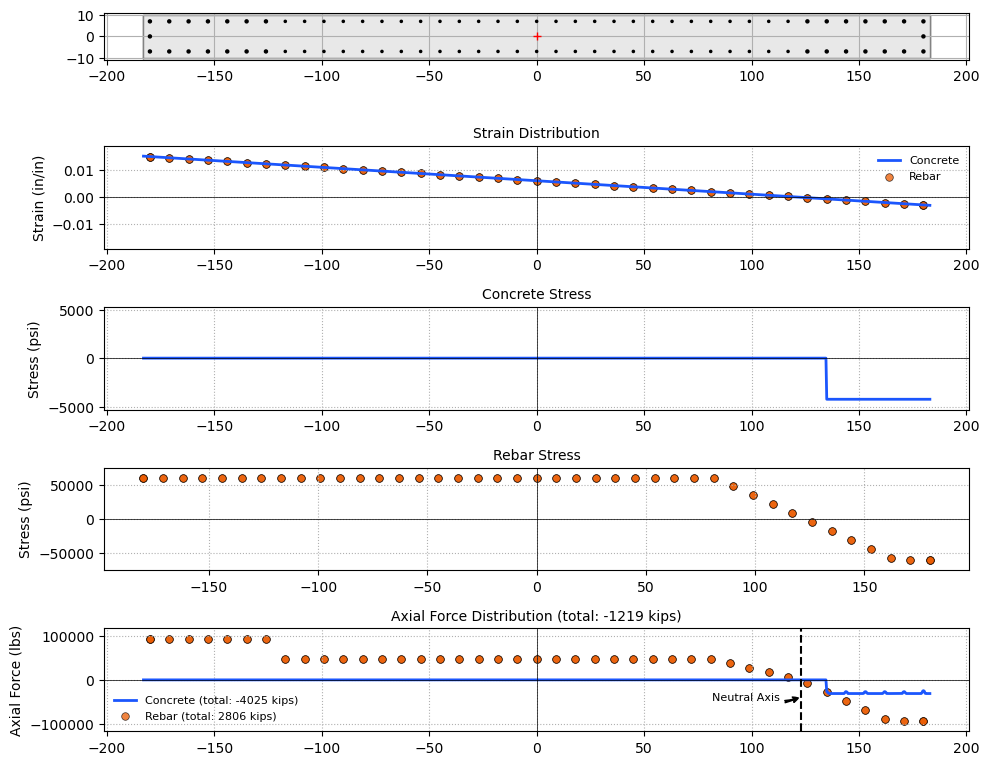

In [10]:
h = max(c_sec.shape.width, c_sec.shape.height) # in

fig, ax = plt.subplots(5, 1, figsize=(10, 8))

ax[0] = c_sec.plot(ax=ax[0], bar_facecolor='black')
ax[1] = plot_section_strain([y_c, y_s], [eps_c, eps_s], ax[1], s=30)
ax[2:4] = plot_section_stress([y_c, y_s], [sigma_c, sigma_s], ax[2:4], s=30)
ax[4] = plot_section_force([y_c,y_s], [f_c, f_s], ax[4], s=30)

ax[4].axvline(x=h/2 - y_neutral, color='black', linestyle='--')
arrowprops = dict(arrowstyle="fancy,head_length=.5,head_width=.5,tail_width=.2", connectionstyle="arc3,rad=0.2", color="black")
ax[4].annotate('Neutral Axis', xy=(h/2 - y_neutral, 1.25*f_c.min()), xytext=(h/2 - y_neutral - 10, 1.5*f_c.min()), arrowprops=arrowprops, fontsize=8, ha='right', color='black')

plt.tight_layout()
plt.show()

In [26]:
y_neutral, force, moment = generate_axial_moment(c_sec, n_points=50, ynmax_multiplier=1)

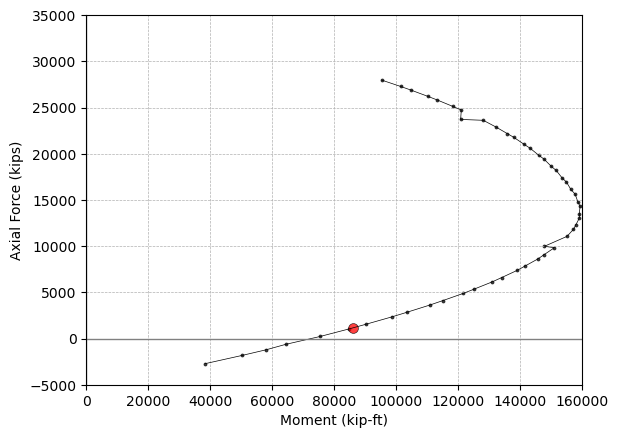

In [27]:
phi=1.0
plt.plot(-phi*moment/1e3/12, -phi*force/1e3, c='black', linewidth=0.5)
plt.scatter(-phi*moment/1e3/12, -phi*force/1e3, s=5, marker='o', c='black', edgecolor='black', linewidth=0.5, alpha=0.75)
plt.scatter(-phi*M_n1[0]/1e3/12, -phi*P_n1/1e3, s=50, marker='o', c='red', edgecolor='black', linewidth=0.5, alpha=0.75)
plt.axhline(y=0, color='grey', linestyle='-', linewidth=1)
plt.axvline(x=0, color='grey', linestyle='-', linewidth=1)
plt.xlabel('Moment (kip-ft)')
plt.ylabel('Axial Force (kips)')
plt.xlim(0, 160e3)
plt.ylim(-5e3, 35e3)
plt.xticks(np.arange(0, 160e3, 40e3), minor=True, fontsize=6)
plt.yticks(np.arange(-5e3, 35e3, 10e3), minor=True, fontsize=6)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

In [43]:
h = max(c_sec.shape.width, c_sec.shape.height) # in
index = -8
c, Pn0, Mn0 = y_neutral.flatten()[index], force[index], moment[index]

curvature = c_sec.mat.eps_u / c

y_s, eps_s, sigma_s, f_s = get_rebar_forces(concrete_sec=c_sec, curvature=curvature, y_neutral=c)
y_c, eps_c, sigma_c, f_c = get_rect_concrete_force(concrete_sec=c_sec, curvature=curvature, y_neutral=c, n_points=100)

P_n = get_section_internal_force(concrete_sec=c_sec, curvature=curvature, y_neutral=c)
M_n = get_section_internal_moment(concrete_sec=c_sec, curvature=curvature, y_neutral=c)

print(f"Neutral axis depth: {c:.2f} in")
print(f"Given (P, M): ({Pn0/1e3:.0f} kips, {Mn0/1e3/12:.0f} kip-ft)")
print(f"Computed (P, M): ({P_n/1e3:.0f} kips, {M_n[0]/1e3/12:.0f} kip-ft)")



Neutral axis depth: 316.67 in
Given (P, M): (-23712 kips, -120724 kip-ft)
Computed (P, M): (-23712 kips, -120724 kip-ft)


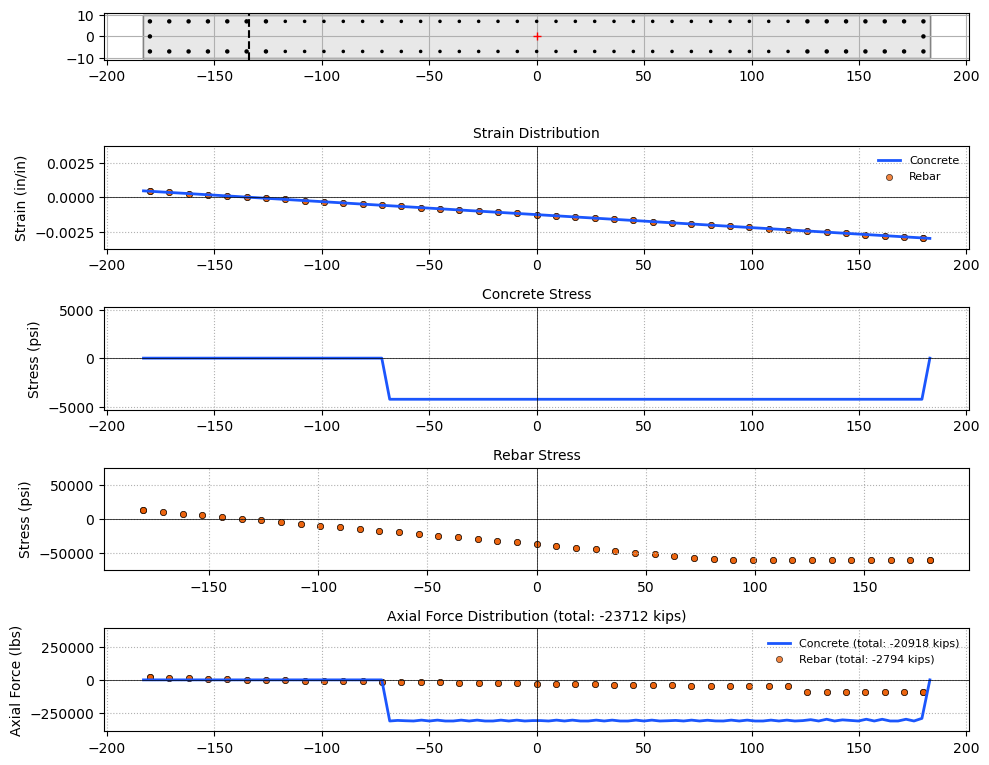

In [44]:
fig, ax = plt.subplots(5, 1, figsize=(10, 8))

ax[0] = c_sec.plot(ax=ax[0], bar_facecolor='black')
ax[0].axvline(x=h/2 - c, color='black', linestyle='--')
ax[1] = plot_section_strain([y_c, y_s], [eps_c, eps_s], ax[1], s=20)
ax[2:4] = plot_section_stress([y_c, y_s], [sigma_c, sigma_s], ax[2:4], s=20)
ax[4] = plot_section_force([y_c,y_s], [f_c, f_s], ax[4], s=20)

plt.tight_layout()
plt.show()

In [15]:
y_c, eps_c, sigma_c, f_c = get_rect_concrete_force(concrete_sec=c_sec, curvature=curvature, y_neutral=c, n_points=100)